# Run this Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-1-Questions/blob/main/HW1_Notebook.ipynb)  
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-1-Questions/blob/main/HW1_Notebook.ipynb)

# HW1: Introduction to RL
> - Full Name: Taha Majlesi
> - Student ID: 810101504


This notebook is designed to provide hands-on experience with RL modeling, algorithm implementation, and performance evaluation. Students will explore RL concepts through predefined environments and custom-designed settings.

Follow the instructions in each section to complete the homework.

## Setup Instructions
Seting up RL dependecies for first time may be challenging. Some  torch or gymnasium (Sklearn lib in SL world!) environments need additional set up on your system. If you encountered error and failure after hours of search and try, feel free to be in contact with TA's.  Run the following commands to install dependencies before starting the notebook:



In [ ]:
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!apt-get install xvfb

In [ ]:
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install swig
!pip install stable-baselines3 "gymnasium[all]" pygame matplotlib numpy pandas

Hamid is CE student who loves learning about RL. He tried to use **Gymnasium** and **Stable-Baselines3** to solve games he played as a kid.  

He started to list the games which was provided in gymnasium library.

In [2]:
from gymnasium import envs

all_envs = envs.registry
env_ids = [env_spec  for env_spec in all_envs]
print("Gymnasium envs listed:",sorted(env_ids))

Gymnasium envs listed: ['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'Blackjack-v1', 'CarRacing-v3', 'CartPole-v0', 'CartPole-v1', 'CliffWalking-v0', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'GymV21Environment-v0', 'GymV26Environment-v0', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'HumanoidStandup-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Taxi-v3', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'W

Then He selected Mountain Car Game to work with:

In [1]:
import gymnasium as gym
env = gym.make("MountainCar-v0", render_mode="rgb_array", goal_velocity=0.1)

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

print("Action Example: {}".format(env.action_space.sample()))
print("State Example: {}".format(env.observation_space.sample()))

Action Space Discrete(3)
State Space Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Example: 2
State Example: [-0.7063208  -0.01518392]


Hamid wanted to visualize the env for better understandig of gym envs. He had two options:


1.   rendering inside the colab
2.   rendering as video file



For ploting the game **inside** the colab he used **pyvirtualdisplay** package:

In [4]:
from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

display = Display(visible=0, size=(400, 300))
display.start()

So He started modify the code to learn how action works and plot it. He selected action of

 *`2: Accelerate to the right`*

For every state of car.

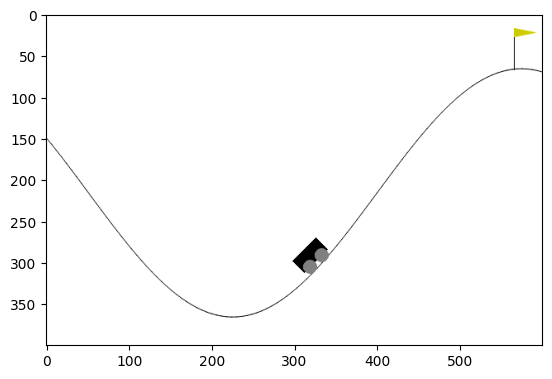

In [5]:
env.reset()
prev_screen = env.render( )
plt.imshow(prev_screen)

for i in range(40):
  # action = env.action_space.sample()  # Random action
  action = 2 # Action Hamid modified to practice
  obs, reward,terminated, truncated, info = env.step(action)
  screen = env.render()

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if terminated:
    break

ipythondisplay.clear_output(wait=True)
env.close()

But for saving game as **video** he defined a function (it's okay if you don't understand just try to run the code and see the output, then try to modify envs!):

In [8]:
import logging
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

training_period = 250  # record the agent's episode every 250
num_training_episodes = 1000  # total number of training episodes

env = gym.make("MountainCar-v0", render_mode="rgb_array")
env = RecordVideo(env, video_folder="MountainCar-v0-agent", name_prefix="training",
                  episode_trigger=lambda x: x % training_period == 0)
env = RecordEpisodeStatistics(env)

for episode_num in range(num_training_episodes):
    obs, info = env.reset()

    episode_over = False
    while not episode_over:
        action = env.action_space.sample()  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)

        episode_over = terminated or truncated

    logging.info(f"episode-{episode_num}", info["episode"])
env.close()

The videos are in MountainCar-v0-agent folder of your colab folder.

But the car couldn't reach the goal state on top of the right hill. So he tried to implement RL algorithm for learning it

In [9]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Parallel environments can bet set but Hamid set 1 env
vec_env = make_vec_env("MountainCar-v0", n_envs=1)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=25000)
model.save("ppo_MountainCar")

del model # remove to demonstrate saving and loading


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -200     |
| time/              |          |
|    fps             | 787      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 200           |
|    ep_rew_mean          | -200          |
| time/                   |               |
|    fps                  | 622           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00041876975 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   |

**Loading saved model**

After training model using PPO and saving it, Hamid started to load the model with the name he saved in cell above:

In [ ]:
model = PPO.load("ppo_MountainCar")

obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    print(obs, rewards, dones, info)
    if dones[0]:
      break

# **Task 1: Solving Predefined Environments (45 points)**
1.1. Choose two environments from the list which are implemented by  other developers and communities and train RL agents using stable-baselines3. Don't forget to check workshop notebook.

**Environments:**
- [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/)
- [FrozenLake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)
- [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/)
- Flappy Bird (Custom env which you can google it)

📊 1.2. Algorithm Comparison:


 Compare RL algorithms and results (at least two algorithms e.g., PPO, DQN) based on:
- Total reward over time
- Hyperparameters (check the docs)


Env1 implementation. [ place for your code ]




In [ ]:
# TODO's:
# Import env 1
# Train env 1
# plot env1 total rewards on sepearate lines for each algorithm
# modify hyperparameters and plot reward curves

Env2 implementation. [ place for your code ]

In [ ]:
# TODO's:
# Import env 2
# Train env 2
# plot env2 total rewards on sepearate lines for each algorithm
# modify hyperparameters and plot reward curves

Write a wrapper for changing reward function and plot the changes. (Bonus)

In [ ]:
# Bonus TODO's: Your wrapper for reward function

# **Task 2: Creating Custom Environment (45 points)**
In this question, you are required to model **a custom 4*4 gridworld problem** as Markov Decision Processes (MDPs). You must define the following components:

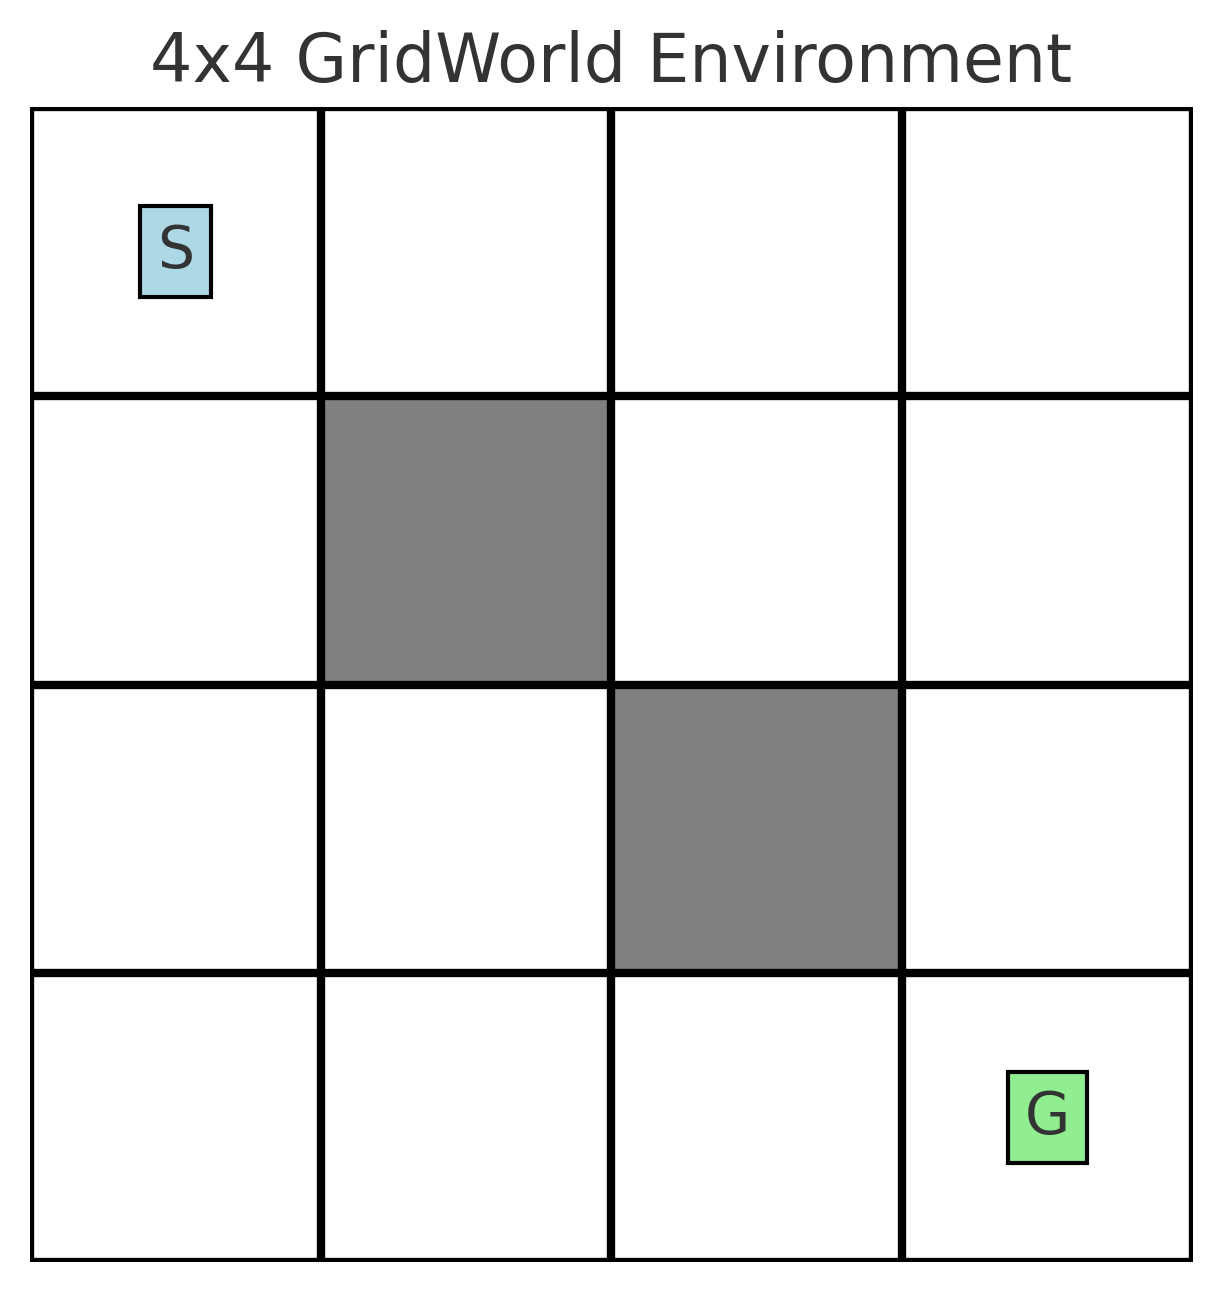

- **State Space ($ S $)**: The set of all possible states the agent can be in.
- **Action Space ($ A $)**: The set of all possible actions the agent can take.
- **Reward Function ($ R $)**: The reward the agent receives for taking an action in a given state.
- **Transition Probability ($ P $)**: The probability of transitioning to a new state given the current state and action. If the environment is deterministic, this can be omitted.

After defining the MDP components, implement problem using the **Gymnasium standard API**. Then, test the environments using various reinforcement learning algorithms (e.g., Q-Learning, DQN, PPO) and evaluate their performance.

In [ ]:
# TODO: Defineing your custom env
class YourAwesomeEnvironment(gym.Env):
    def __init__(self) -> None:
        super().__init__()
        self.action_space = ...
        self.observation_space = ...

    def step(
        self, action: Any
    ) -> tuple[Any, SupportsFloat, bool, bool, dict[str, Any]]:
        return super().step(action)

    def reset(
        self, *, seed: int | None = None, options: dict[str, Any] | None = None
    ) -> tuple[Any, dict[str, Any]]:
        return super().reset(seed=seed, options=options)

    #Optional
    def render(self):
        return super().render()

    def close(self):
        return super().close()

In [ ]:
# TODO: Training agent on your env

📊 Algorithm Comparison
Compare RL algorithms (e.g., PPO, DQN) based on:
- Total reward over time
- Sample efficiency
- Hyperparameters


In [ ]:
# TODO: Algorithm comparison code

# **Task 3: Pygame 🎮 Tutorial & Custom RL Environment (Bonus)**

In this bonus task, you will implement a custom RL environment using Pygame and make it Gym-compatible for training an RL agent. Pygame is widely used for 2D game development and can be an excellent tool for creating custom RL environments. You will start by learning basic Pygame concepts (game loop, rendering, input handling), then implement a simple grid-based environment where an agent moves toward a goal while avoiding obstacles. Finally, you will train an RL agent using Stable-Baselines3 (SB3) to solve the environment. If you’re looking for inspiration, consider recreating the Chrome Dino game 🦖 as an RL environment which will be introduced at workshop or future TA sessions, but feel free to explore your own ideas!

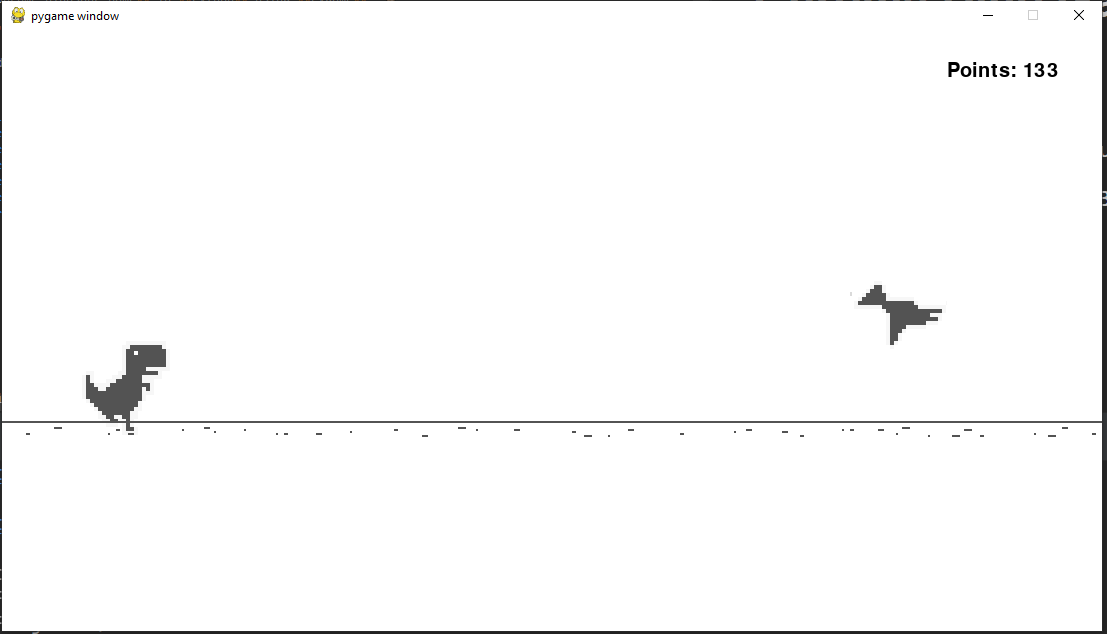